In [1]:
import pandas as pd
import torch

import os
import sys
sys.path.append(os.path.abspath('..'))
from scripts.training import run_epoch, train_loop
from utils import move_data_to_device, move_dict_to_cpu, plot_image, plot_image_boxes
from PsfSimulator import PsfDataset
from models.subpix_rcnn import SubpixRCNN
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.ops import MultiScaleRoIAlign
from torchvision.ops import misc as misc_nn_ops
from torchvision.transforms._presets import ObjectDetection
from torchvision.models._api import register_model, Weights, WeightsEnum
from torchvision.models._meta import _COCO_CATEGORIES
from torchvision.models._utils import _ovewrite_value_param, handle_legacy_interface
from torchvision.models.resnet import resnet50, ResNet50_Weights
from torchvision.models.detection._utils import overwrite_eps
from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor, _validate_trainable_layers
from torchvision.models.detection.faster_rcnn import _default_anchorgen, FasterRCNN, FastRCNNConvFCHead, RPNHead
from torchvision.models.detection.roi_heads import RoIHeads

from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.generalized_rcnn import GeneralizedRCNN
import torch.nn.functional as F
import torch.optim as optim
import os
import datetime

In [2]:
# Density 1 = 40 spots per 64x64 image
# Density 0.05 = 2 spots per 64x64 image

In [3]:
# Instatiate the dataset
seed = None

num_spots_min = 0
num_spots_max = 80
sigma_mean= 1.5
sigma_std = 0.1
snr_min = 2
snr_max = 15
snr_std = 0.0
base_noise_min = 300
base_noise_max = 10000
use_gauss_noise = False
gauss_noise_std = 0.0
use_perlin_noise = True
perlin_min_max = None#(0.4, 0.6)
img_w = 64
img_h = 64

train_dataset = PsfDataset(seed, 2000, num_spots_min, num_spots_max, sigma_mean, sigma_std,
                      snr_min, snr_max, snr_std, base_noise_min, base_noise_max, use_gauss_noise,
                      gauss_noise_std, use_perlin_noise, perlin_min_max, img_w, img_h)


valid_dataset = PsfDataset(seed, 100, num_spots_min, num_spots_max, sigma_mean, sigma_std,
                      snr_min, snr_max, snr_std, base_noise_min, base_noise_max, use_gauss_noise,
                      gauss_noise_std, use_perlin_noise, perlin_min_max, img_w, img_h)


# Print the number of samples in the training and validation datasets
print(pd.Series({
    'Training dataset size:': len(train_dataset),
    'Validation dataset size:': len(valid_dataset)}))

data_loader_params = {'batch_size':8,    'collate_fn': lambda batch: tuple(zip(*batch)),}

training_loader = torch.utils.data.DataLoader(train_dataset, **data_loader_params)
validation_loader = torch.utils.data.DataLoader(valid_dataset, **data_loader_params)

Training dataset size:      2000
Validation dataset size:     100
dtype: int64


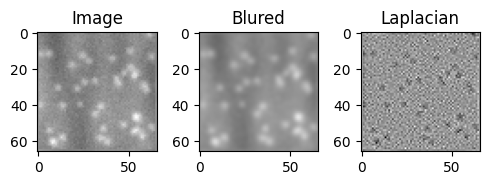

In [4]:
example = train_dataset[0][0]
min_val = example.min()
max_val = example.max()
fig, ax = plt.subplots(1, 3, figsize=(5, 5))
ax[0].imshow(example[0], cmap='gray', vmin=min_val, vmax=max_val)
ax[0].set_title('Image')
ax[1].imshow(example[1], cmap='gray', vmin=min_val, vmax=max_val)
ax[1].set_title('Blured')
ax[2].imshow(example[2], cmap='gray')
ax[2].set_title('Laplacian')
plt.tight_layout()

In [5]:
def generate_checkpoint_path(model_name, project_name):

  # 1. Define the project directory within Colab's content area
  folder_path = os.path.join(os.curdir, project_name)

  # 2. Create the directory if it doesn't exist
  os.makedirs(folder_path, exist_ok=True)

  # 3. Generate a timestamped subdirectory
  timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
  checkpoint_dir = os.path.join(folder_path, timestamp)
  os.makedirs(checkpoint_dir, exist_ok=True)

  # 4. Construct the checkpoint path
  checkpoint_path = os.path.join(checkpoint_dir, f"{model_name}.pth")

  return checkpoint_path

In [6]:
from torch.utils.tensorboard import SummaryWriter

In [7]:
writer = SummaryWriter('runs/w_zero_spots')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

backbone = resnet_fpn_backbone("resnet50", weights=None, trainable_layers=5)
kwargs = {"nms_tresh": 0.1, "image_mean":[0,0,0], "image_std":[1,1,1] }

model = SubpixRCNN(backbone, num_classes=2, device=device, **kwargs)
model.to(device)
model.name = "testmodel"
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# path = r"D:\zeiss\Desktop\coding\Hilger\bachelor\notebooks\subpix_rcnn_models\2025-05-27_18-10-28\second_long_run.pth"
# model.load_state_dict(torch.load(path, map_location=device))

checkpoint_path = generate_checkpoint_path("second_run", "w_zero_spots")
num_epochs = 400

train_loop(model, training_loader, validation_loader, optimizer, device, num_epochs, checkpoint_path, writer)

cuda


c:\Users\zeiss\anaconda3\envs\hilger312\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Custom SubpixRoIHeads successfully initialized!


Training Loop:   0%|          | 0/400 [00:00<?, ?it/s]

Train:   0%|          | 0/250 [00:00<?, ?it/s]

d:\zeiss\Desktop\coding\Hilger\bachelor\PsfSimulator.py:128: RuntimeWarning: All-NaN slice encountered
  signal = np.nanmax(array[y1:y2, x1:x2])


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

New best loss: 0.7019609212875366


Train:   0%|          | 0/250 [00:00<?, ?it/s]